# Polygon Simplification

This guide demonstrates customizing polygon requests to simplify the geometry of the returned polygons.

Contrails API supports both [GeoJSON](https://geojson.org/) and [KML](https://developers.google.com/kml/documentation/kmlreference) polygon formats. We only work with GeoJSON polygons in this notebook.

This notebook uses [Shapely](https://shapely.readthedocs.io/en/latest/index.html) to interact with polygons. In particular, [GEOS](https://shapely.readthedocs.io/en/latest/reference/shapely.from_geojson.html) is required to convert GeoJSON to Shapely polygons.

In [1]:
import json
import os
from pprint import pprint

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import pandas as pd
import requests
import shapely

In [2]:
# Define credentials
URL = "https://api.contrails.org"
api_key = os.environ["CONTRAILS_API_KEY"]
headers = {"x-api-key": api_key}

## Query parameters

The following query parameters are used in the [/v0/grid/issr](https://api.contrails.org/openapi#/Research/ice_super_saturated_regions_v0_grid_issr_get) endpoint:

- `time`: The time for the polygon prediction. Must be an ISO 8601 datetime string or unix timestamp (seconds since epoch).
- `format`: Set `format=geojson` to return polygons in GeoJSON format.
- `interiors`: Set `interiors=true` to return [interior polygons](#Interior-polygons).
- `simplify`: Used to control the extent to which polygon [geometry is simplified](#The-simplify-query-parameter).
- `convex_hull`: Set `convex_hull=true` to return the [convex hull](#Experimental:-convex-hulls) of the polygon.
- `bbox`: Used to downselect horizontally.
- `flight_level`: Used to downselect vertically.

## Default parameters

Here, we request ISSR polygons at a single flight level using the default polygon simplify parameters.

In [3]:
params = {
    "time": "2023-02-10",
    "format": "geojson",
    "flight_level": 360,
}

r = requests.get(f"{URL}/v0/grid/issr", params=params, headers=headers)
print(f"HTTP Response Code: {r.status_code} {r.reason}")

HTTP Response Code: 200 OK


In [4]:
geojson = r.json()
feature = geojson["features"][0]

# Print out the metadata
pprint(feature["properties"])

# Convert the output to shapely
# Unfortunately, GEOS can't handle the altitude coordinate returned by the API
# Manually loop through and remove it
for coords in feature["geometry"]["coordinates"]:
    for poly in coords:
        for point in poly:
            del point[2]

multipoly = shapely.from_geojson(json.dumps(feature))

{'description': 'Ice super-saturated regions',
 'humidity_scaling_formula': 'era5_quantiles -> iagos_quantiles',
 'humidity_scaling_name': 'histogram_matching',
 'level': 360,
 'level_long_name': 'Flight Level',
 'level_standard_name': 'FL',
 'level_units': 'hectofeet',
 'met_source_dataset': 'ERA5',
 'met_source_product': 'reanalysis',
 'met_source_provider': 'ECMWF',
 'name': 'issr',
 'polygon_iso_value': 0.5,
 'pycontrails_version': '0.52.1',
 'time': '2023-02-10T00:00:00Z'}


### Polygon topology

GeoJSON polygons have both interior and exterior boundaries. Below use red for exterior boundaries and blue for interior boundaries.

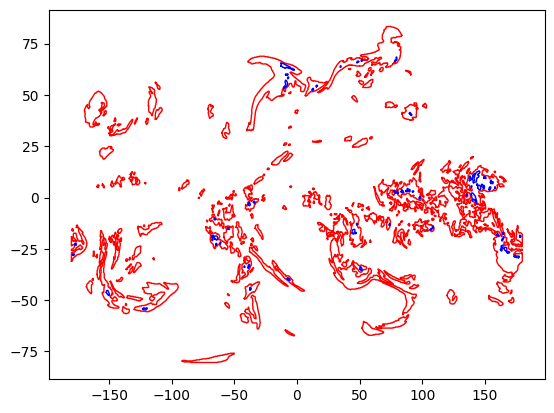

In [5]:
for poly in multipoly.geoms:
    plt.plot(*poly.exterior.xy, color="red", lw=1)
    for interior in poly.interiors:
        plt.plot(*interior.xy, color="blue", lw=1)

In [6]:
# Print some statistics on the polygons
n_exterior_rings = len(multipoly.geoms)
n_interior_rings = sum(len(p.interiors) for p in multipoly.geoms)
n_exterior_vertices = sum(len(p.exterior.coords) for p in multipoly.geoms)
n_interior_vertices = sum(len(i.coords) for p in multipoly.geoms for i in p.interiors)
area = multipoly.area

print(f"Number of exterior rings: {n_exterior_rings}")
print(f"Number of interior rings: {n_interior_rings}")
print(f"Number of exterior vertices: {n_exterior_vertices}")
print(f"Number of interior vertices: {n_interior_vertices}")
print(f"Total area: {area}")  # units are in the image of the Plate carree projection

Number of exterior rings: 243
Number of interior rings: 68
Number of exterior vertices: 12956
Number of interior vertices: 824
Total area: 5272.312050000002


In [7]:
# Formalize some of cells above into functions for later use
def get_shapely(**kwargs):
    params = {
        "time": "2023-02-10",
        "format": "geojson",
        "flight_level": 360,
    }
    params.update(kwargs)

    r = requests.get(f"{URL}/v0/grid/issr", params=params, headers=headers)
    r.raise_for_status()

    geojson = r.json()
    (feature,) = geojson["features"]

    for coords in feature["geometry"]["coordinates"]:
        for poly in coords:
            for point in poly:
                del point[2]

    return shapely.from_geojson(json.dumps(feature))


def polygon_metrics(multipoly):
    n_exterior_rings = len(multipoly.geoms)
    n_interior_rings = sum(len(p.interiors) for p in multipoly.geoms)
    n_exterior_vertices = sum(len(p.exterior.coords) for p in multipoly.geoms)
    n_interior_vertices = sum(len(i.coords) for p in multipoly.geoms for i in p.interiors)
    area = multipoly.area
    return {
        "n_exterior_rings": n_exterior_rings,
        "n_interior_rings": n_interior_rings,
        "n_exterior_vertices": n_exterior_vertices,
        "n_interior_vertices": n_interior_vertices,
        "area": area,
    }

## Interior polygons

Set the query parameter `interiors=false` to only return exterior polygons.

As seen in the `polygon_metrics` output and in the plot, the exterior polygons remain the same as before, but the interior polygons are removed.

In [8]:
multipoly = get_shapely(interiors=False)

print(polygon_metrics(multipoly))

for poly in multipoly.geoms:
    plt.plot(*poly.exterior.xy, color="red", lw=1)
    assert len(poly.interiors) == 0

{'n_exterior_rings': 243, 'n_interior_rings': 0, 'n_exterior_vertices': 12956, 'n_interior_vertices': 0, 'area': 5391.80365}


## The `simplify` query parameter

Use the `simplify` query parameter to customize the extent to which polygon boundaries are simplified. This parameter is an integer between 0 and 10, inclusive. A value of 0 means no simplification. A value of 10 simplifies aggressively (thereby introducing some error). The default value is 3. A higher value also drops more small polygons.

In [9]:
multipoly_list = [get_shapely(interiors=False, simplify=s) for s in range(0, 11)]

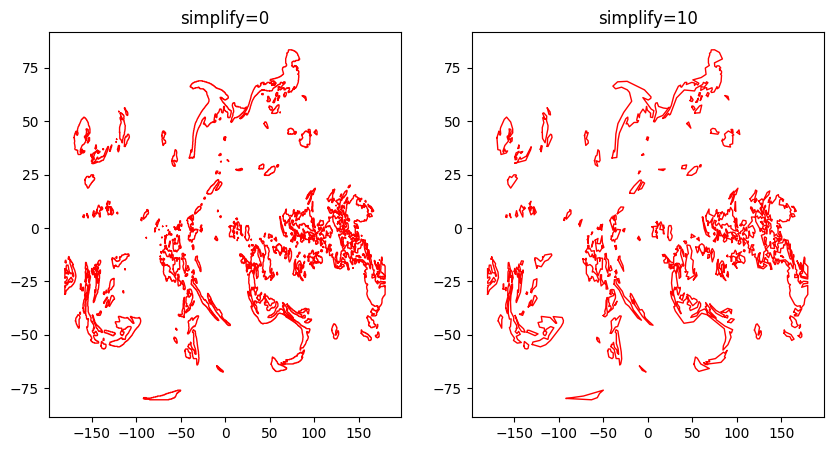

In [10]:
# Plot the least and most aggressively simplified polygons side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_title("simplify=0")
multipoly = multipoly_list[0]
for poly in multipoly.geoms:
    ax1.plot(*poly.exterior.xy, color="red", lw=1)

ax2.set_title("simplify=10")
multipoly = multipoly_list[-1]
for poly in multipoly.geoms:
    ax2.plot(*poly.exterior.xy, color="red", lw=1)

### Metrics

Make a table showing how the number of polygons and vertices changes with different values of `simplify`.

In [11]:
df = pd.DataFrame([polygon_metrics(m) for m in multipoly_list])
df = df.rename_axis("simplify")
df

n_exterior_rings  n_interior_rings  n_exterior_vertices  \
simplify                                                            
0                      308                 0                18215   
1                      266                 0                17971   
2                      257                 0                14004   
3                      243                 0                12956   
4                      238                 0                10282   
5                      233                 0                 7126   
6                      226                 0                 5364   
7                      210                 0                 4328   
8                      204                 0                 3633   
9                      196                 0                 3185   
10                     186                 0                 2155   

          n_interior_vertices        area  
simplify                                   
0                           0  5428.75570  
1                           0  5426.39900  
2                           0  5406.37095  
3                           0  5391.80365  
4                           0  5385.11330  
5                           0  5379.95495  
6                           0  5374.52980  
7                           0  5349.90020  
8                           0  5334.65810  
9                           0  5317.85205  
10                          0  5206.62255

### Visualize

Visualize how a few of the larger polygons vary with `simplify`.

In [12]:
p0 = shapely.Point(-17, 50)

fig, ax = plt.subplots()
for i, multipoly in enumerate(multipoly_list[::2]):
    for p in multipoly.geoms:
        if p.contains(p0):
            ax.plot(*p.exterior.xy, label=f"simplify={i*2}")

ax.legend();

In [13]:
p0 = shapely.Point(-120, -54)

fig, ax = plt.subplots()
for i, multipoly in enumerate(multipoly_list[::2]):
    for p in multipoly.geoms:
        if p.contains(p0):
            ax.plot(*p.exterior.xy, label=f"simplify={i*2}")

ax.legend();

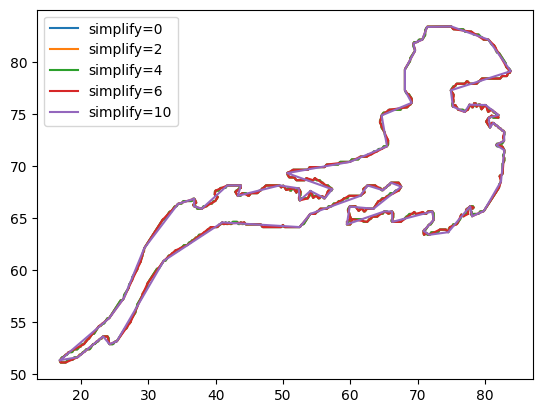

In [14]:
p0 = shapely.Point(55, 67)

fig, ax = plt.subplots()
for i, multipoly in enumerate(multipoly_list[::2]):
    for p in multipoly.geoms:
        if p.contains(p0):
            ax.plot(*p.exterior.xy, label=f"simplify={i*2}")

ax.legend();

## Convex hulls

Use the boolean `convex_hull` query parameter to simplify polygons by computing their convex hulls. When this parameter is enabled, the `interiors` parameter is automatically set to `false`.

This purpose of this parameter is to:

- Further reduce the complexity of the polygon geometry.
- Fill in "fjords" and other gaps in the polygon geometry. If polygons are regions to be avoided, points outside of a polygon but inside its convex hull may still be inaccessible for trajectory planning. By explicitly taking a convex hull, the flight planner may have an easier time creating optimal trajectories.

As seen in the table below, the number of polygons (`n_exterior_rings`) and the number of vertices are reduced when using the `convex_hull` parameter. On the other hand, the total footprint of the polygons is increased (as measured by the `area` metric).

In [15]:
multipoly_list_ch = [get_shapely(convex_hull=True, simplify=s) for s in range(0, 11)]

In [16]:
df1 = (
    df.drop(columns=["n_interior_rings", "n_interior_vertices"])
    .assign(convex_hull=False)
    .rename_axis("simplify", axis=0)
    .set_index("convex_hull", append=True)
)

df2 = pd.DataFrame([polygon_metrics(m) for m in multipoly_list_ch])
df2 = (
    df2.drop(columns=["n_interior_rings", "n_interior_vertices"])
    .assign(convex_hull=True)
    .rename_axis("simplify", axis=0)
    .set_index("convex_hull", append=True)
)

df = pd.concat([df1, df2], axis=0)
df.sort_index()

n_exterior_rings  n_exterior_vertices         area
simplify convex_hull                                                    
0        False                     308                18215   5428.75570
         True                      204                 2891  11404.67800
1        False                     266                17971   5426.39900
         True                      181                 2675  11401.79705
2        False                     257                14004   5406.37095
         True                      174                 2388  11395.14875
3        False                     243                12956   5391.80365
         True                      168                 2071  11383.98305
4        False                     238                10282   5385.11330
         True                      166                 1836  11367.97765
5        False                     233                 7126   5379.95495
         True                      162                 1566  11337.67915
6        False                     226                 5364   5374.52980
         True                      158                 1413  11292.63095
7        False                     210                 4328   5349.90020
         True                      147                 1226  11256.84365
8        False                     204                 3633   5334.65810
         True                      143                 1097  11202.22925
9        False                     196                 3185   5317.85205
         True                      137                 1007  11158.91640
10       False                     186                 2155   5206.62255
         True                      129                  805  10982.87520

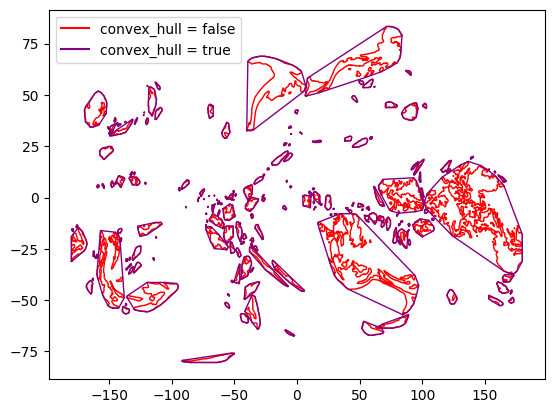

In [17]:
fig, ax = plt.subplots()

for poly in multipoly_list[0].geoms:
    ax.plot(*poly.exterior.xy, color="red", lw=1)

for poly in multipoly_list_ch[0].geoms:
    ax.plot(*poly.exterior.xy, color="purple", lw=1)

red_line = mlines.Line2D([], [], color="red", label="convex_hull = false")
purple_line = mlines.Line2D([], [], color="purple", label="convex_hull = true")
ax.legend(handles=[red_line, purple_line]);

## Contrail forecast polygons (`/v1`)

Contrail forecast data served from the `/v1/` API endpoints have pre-selected parameters for polygon generation.

Under the hood, forecast polygon regions are generated with the pycontrails [MetDataArray.to_polygon_feature](https://py.contrails.org/api/pycontrails.MetDataArray.html#pycontrails.MetDataArray.to_polygon_feature) method.

For input `forecast_data` [DataArray](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html) and  `threshold` value, polygons are generated with the parameters:

```python
MetDataArray(forecast_data).to_polygon_feature(**{
    iso_value=threshold,
    fill_value=0.0,
    min_area=1.0,  # corresponds to "simplify=10" query parameter above
    epsilon=0.5,   # corresponds to "simplify=10" query parameter above
    precision=2,   # for computational efficiency
    interiors=False,
    convex_hull=False,
    include_altitude=True,
    lower_bound=True
})
```

See [Contrail Forecast /v1](forecast_api.html) notebook for details on accessing forecast polygons.